### Initialize

In [1]:
# Install a few python packages using pip
#from w266_common import utils
#utils.require_package("wget")      # for fetching dataset

# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse

# Visualize
import matplotlib.pyplot as plt

# NLTK for NLP utils
import nltk

# PCA 
from sklearn.decomposition import PCA

# Helper libraries
from w266_common import utils, vocabulary, tf_embed_viz

/home/juliab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import GloVe dataset
Contains 6B tokens from Wikipedia 2014 + Gigawords 5.

(will take a while to run)

In [2]:
import glove_helper; reload(glove_helper)

hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [3]:
import vector_math; reload(vector_math)

def show_nns(hands, word, k=10):
    """Helper function to print neighbors of a given word."""
    word = word.lower()
    print("Nearest neighbors for '{:s}'".format(word))
    v = hands.get_vector(word)
    for i, sim in zip(*vector_math.find_nn_cos(v, hands.W, k)):
        target_word = hands.vocab.id_to_word[i]
        print("{:.03f} : '{:s}'".format(sim, target_word))
    print("")
    
def show_analogy(hands, a, b, c, k=5):
    """Compute and print a vector analogy."""
    a, b, c = a.lower(), b.lower(), c.lower()
    va = hands.get_vector(a)
    vb = hands.get_vector(b)
    vc = hands.get_vector(c)
    print("'{a:s}' is to '{b:s}' as '{c:s}' is to ___".format(**locals()))
    for i, sim in zip(*vector_math.analogy(va, vb, vc, hands.W, k)):
        target_word = hands.vocab.id_to_word[i]
        print("{:.03f} : '{:s}'".format(sim, target_word))
    print("")


## PCA

In [4]:
# first check on gender pairs
# length = 9
gender_pairs = [("she","he"),("her","his"),("woman","man"),
                ("herself","himself"),("daughter","son"),("mother","father"),
                ("gal","guy"),("girl","boy"),("female","male")]

# Mary not found in vocabulary??
# length = 10
gender_pairs_orig = [("she","he"),("her","his"),("woman","man"),("Mary","John"),
                ("herself","himself"),("daughter","son"),("mother","father"),
                ("gal","guy"),("girl","boy"),("female","male")]


In [5]:
# get embedding of a word
def get_embed(a):
    return hands.get_vector(a)

# calculate difference of vectors to determine bias direction
# a and b are strings
def get_diff(a,b):
    return(get_embed(a) - get_embed(b))

def get_diffs(l):
    return [get_diff(a,b) for a,b in l]

# plot top two principal components....
# create a scatter plot of the projection
def plot_2d(pcs,words):
    plt.scatter(pcs[:, 0], pcs[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(pcs[i, 0], pcs[i, 1]))
    plt.show()

### Gender PCA

In [6]:
diffs_gen = get_diffs(gender_pairs)

In [7]:
pca_gen = PCA(n_components=10)

In [8]:
result_polit = pca_gen.fit_transform(diffs_gen)

Explained variance seems approximately consistent with paper. They show first component right around 60% of explained variance, second at maybe 13%, third at 10%, 4%, and then dropoff to very small. 

We get 60%, 17%, 7%, 6%.... 

In [9]:
result_polit.shape # All variance explained in 9 PCs.

(9, 9)

In [10]:
print(pca_gen.explained_variance_ratio_)
print(sum(pca_gen.explained_variance_ratio_))

[5.99730564e-01 1.67434544e-01 7.53068220e-02 6.45831901e-02
 4.40725264e-02 2.16965765e-02 1.71100518e-02 1.00657256e-02
 1.72871980e-32]
1.0


<Container object of 9 artists>

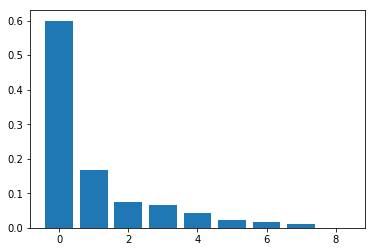

In [11]:
plt.bar(range(result_polit.shape[0]),pca_gen.explained_variance_ratio_)

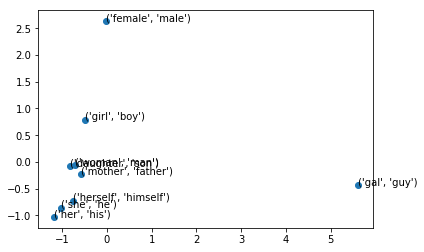

In [12]:
plot_2d(result_polit,gender_pairs)

### Political PCA

In [13]:
# start with the four we are most confident about
polit_pairs = [("democrat","republican"),("liberal","conservative"),("liberalism","conservatism"),
               ("left-wing","right-wing")]

polit_pairs_2 = [("democrat","republican"),("liberal","conservative"),("liberalism","conservatism"),
               ("left-wing","right-wing"),("donkey","elephant")]

In [14]:
diffs_polit = get_diffs(polit_pairs_2) # update this between the two lists of pairs

pca_polit = PCA(n_components=10)

result_polit = pca_polit.fit_transform(diffs_polit)

In [15]:
print(result_polit.shape) # All variance explained in few dimensions - this in itself may be interesting?

(5, 5)


With just `polit_pairs`, we get 4 PCs with the following percentages of explained variance: 52%, 30%, 17%, and very small. If we add in "donkey" and "elephant" to `polit_pairs_2` just for kicks, we get 5 PCs with: 59%, 22%, 12%, 7%, and very small. Does this make sense?

In [16]:
print(pca_polit.explained_variance_ratio_)
print(sum(pca_polit.explained_variance_ratio_))

[5.87667034e-01 2.15656574e-01 1.24597618e-01 7.20787733e-02
 9.68888656e-33]
1.0


<Container object of 5 artists>

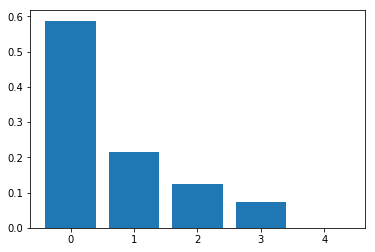

In [17]:
# how do we know this is significant enough of a drop off?
plt.bar(range(result_polit.shape[0]),pca_polit.explained_variance_ratio_)

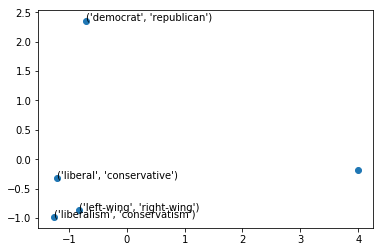

In [18]:
plot_2d(result_polit,polit_pairs)